<a href="https://colab.research.google.com/github/bcrompvoets/Star_Formation/blob/main/SF_Classify_StackingEnsemble_SVC_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Class I, II, and others using Support Vectors Classification

Using data from the four IRAC bands (3.6, 4.5, 5.8, and 8  μm), we classify each object as "other", Class I or Class II protostars. We use an ensemble of SVC and Logistic Regression (with parameters determined by previous GridSearches). 

This data comes from Cornu and Montillaud (2021) (https://cdsarc.cds.unistra.fr/viz-bin/cat/J/A+A/647/A116) and includes Spitzer data of the Orion and NGC 2264 star forming regions.

In [21]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, svm, datasets
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC 
from sklearn.ensemble import StackingClassifier
import itertools
from sklearn.metrics import confusion_matrix

In [22]:
# Loading input and target features from files, normalize

X = np.load("Input_Class_AllClasses.npy") # Load input data
Y = np.load("Target_Class_AllClasses.npy") # Load target data

inp_tr, inp_va, tar_tr, tar_va = train_test_split(X, Y, test_size=0.25 )

print ('Training set == ',np.shape(inp_tr),np.shape(tar_tr),', Validation set == ', np.shape(inp_va),np.shape(tar_va))

scaler_S= StandardScaler().fit(inp_tr)  # find parameters of fitting model based on training set

inp_tr= scaler_S.transform(inp_tr) # Normalized training set

inp_va= scaler_S.transform(inp_va)  # Normalized validation set (using normalization from training set)

Training set ==  (20177, 8) (20177, 1) , Validation set ==  (6726, 8) (6726, 1)


Testing a number of parameter spaces varying the type of kernel, the value of gamma, and the value of C.

In [23]:
# Specify the estimators for use in the stacking ensemble
estimators = [('svc', SVC(kernel='rbf',gamma='auto',C=0.9,random_state=42))]

stacl = StackingClassifier(estimators=estimators,final_estimator=LogisticRegression())

In [24]:
start = time.time()

stacl.fit (inp_tr,tar_tr.ravel())  # fit the model with training set

end = time.time()
time_taken = (end - start)/60
print ('Time Taken: ',time_taken)

Time Taken:  0.4446800867716471


In [25]:
# Find the predicted values
pred_tr = stacl.predict(inp_tr)
pred_va = stacl.predict(inp_va)

Normalized confusion matrix
[[0.872 0.043 0.085]
 [0.029 0.944 0.027]
 [0.002 0.016 0.982]]


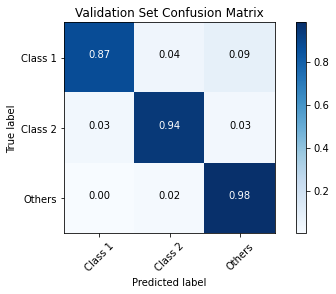

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Compute confusion matrix
cnf_matrix_va = confusion_matrix(pred_va, tar_va)
np.set_printoptions(precision=3)


# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_va, classes=['Class 1','Class 2', 'Others'], normalize=True,
                      title='Validation Set Confusion Matrix')

#plt.show()

Normalized confusion matrix
[[0.899 0.029 0.072]
 [0.028 0.946 0.026]
 [0.001 0.013 0.985]]


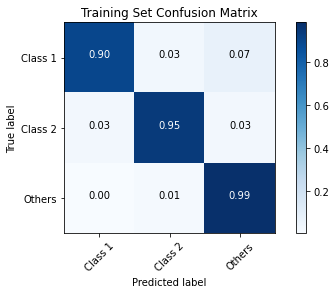

In [27]:
# Compute confusion matrix
cnf_matrix_tr = confusion_matrix(pred_tr, tar_tr)
np.set_printoptions(precision=3)


# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_tr, classes=['Class 1','Class 2', 'Others'], normalize=True,
                      title='Training Set Confusion Matrix')

In [28]:
# grid.best_params_

In [29]:
stacl.classes_

array([0, 1, 2])

In [30]:
print(metrics.accuracy_score(tar_tr,pred_tr),metrics.accuracy_score(tar_va,pred_va))

0.9802250086732418 0.9772524531668153


<class 'numpy.ndarray'>
Normalized confusion matrix
[[0.893 0.032 0.075]
 [0.028 0.946 0.026]
 [0.001 0.014 0.985]]


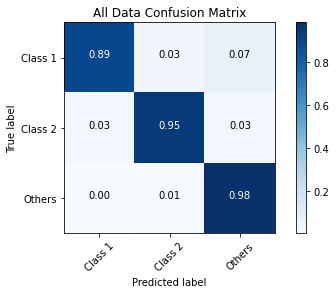

In [31]:
print(type(tar_tr))
tar_all = np.concatenate([tar_tr,tar_va])
pred_all = np.concatenate([pred_tr,pred_va])

# Compute confusion matrix
cnf_matrix_all = confusion_matrix(pred_all, tar_all)
np.set_printoptions(precision=3)


# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_all, classes=['Class 1','Class 2', 'Others'], normalize=True,
                      title='All Data Confusion Matrix')

# Discussion

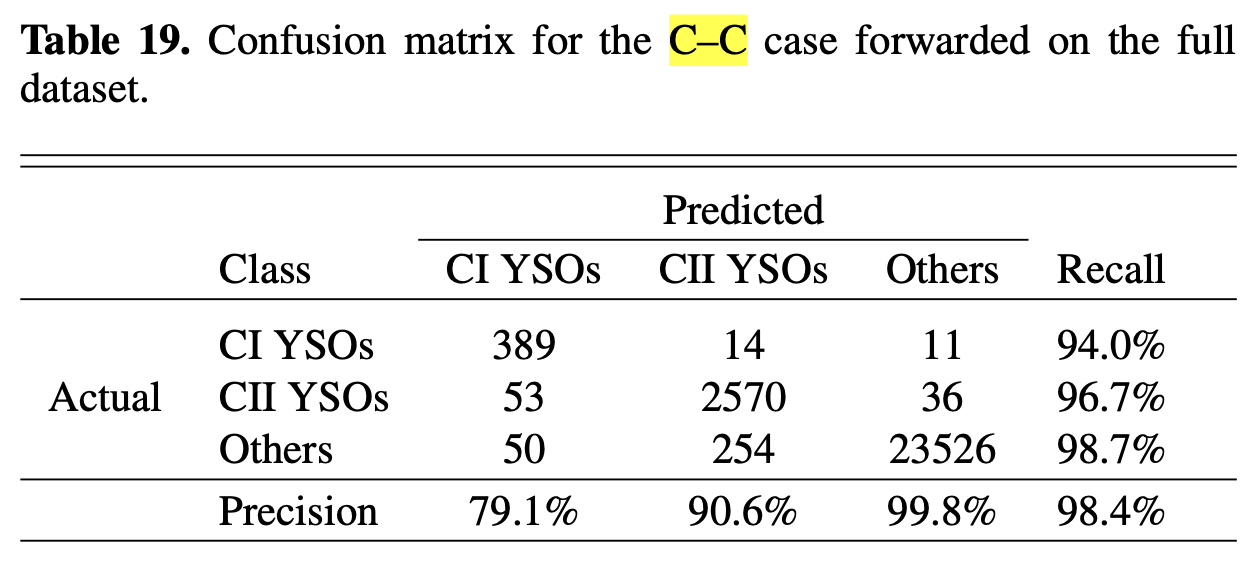

The above figure shows the results of Cornu & Montillaud using a neural-network approach. 


Using a stacking ensemble of SVC and Logistic Regression, we obtain even higher recall for Class 1 than in either of the two cases separately, although not yet at the level of the Cornu paper. 

# FUTURE:

- Ensembles:
  - Stacking (multiple layers of SVC)
  - Boosting (SVC and Logistic Regression)
  - XGBoost
- Try PCA
- Learn how to apply algorithm to unlabelled data.
- Apply to all classes available in orginal data (Class I, Class II, Shocks, Galaxies, PAH's, Stars)